In [303]:
# Cell 2 - imports and load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import random

# ML libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# load weekly aggregated data
PATH = "aggregated_data/weekly_features.csv" 
df = pd.read_csv(PATH, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

DATE_COL = "Date"
TARGET_COL = "total_sales"

print("Loaded", PATH, "rows:", len(df))
display(df.head(3))


Loaded aggregated_data/weekly_features.csv rows: 65


,Date,total_sales,n_orders,total_quantity,avg_unit_price,avg_session_duration,avg_pages_viewed,pct_returning,avg_discount_amount,has_discount_rate,...,avg_qty_per_order,unique_customers,orders_per_customer,returning_times_session,discountrate_times_qty,category_share_Electronics,category_share_Home & Garden,category_share_Sports,category_share_Fashion,category_share_Toys
0,2023-01-02,80246.01,67,193,415.496119,14.388060,9.044776,0.582090,43.464328,0.417910,...,2.880597,67,1.000000,8.375139,1.203832,0.519320,0.190078,0.066568,0.090124,0.045320
1,2023-01-09,300235.22,254,763,448.612992,14.500000,9.031496,0.602362,57.833465,0.374016,...,3.003937,252,1.007937,8.734252,1.123520,0.419759,0.197702,0.197547,0.058083,0.042290
2,2023-01-16,281004.20,268,785,393.871791,14.425373,9.000000,0.641791,58.350000,0.402985,...,2.929104,259,1.034749,9.258075,1.180385,0.365671,0.182891,0.203321,0.116558,0.049825


In [304]:
# Cell 3 - config
MIN_HISTORY = 6        # minimum weeks required before training starts
MA_WINDOW = 5          # fallback moving-average window
SEQ_LEN = 8            # number of past steps used by GRU (adjust: 4-12 typical)
BATCH_SIZE = 8
EPOCHS = 200
PATIENCE = 12          # early stopping patience
HIDDEN_SIZE = 16
NUM_LAYERS = 1
LEARNING_RATE = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cpu


In [305]:
TARGET_COL = "total_sales"
DATE_COL = "Date"

FEATURE_COLS = [
    "total_sales",        
    # "total_sales_lag_1",
    "total_sales_lag_2",
    # "total_sales_lag_4",
    # "total_sales_rollmean_4",
    # "total_sales_rollstd_4",
    # "week_idx"
]


In [306]:
# Cell 4 - metrics
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape_robust(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0

def me(y_true, y_pred):
    return float(np.mean(np.array(y_pred) - np.array(y_true)))


In [307]:
# Cell 5 - dataset helper and sequence creation functions

def drop_nan_sequences(X, y):  # To combat the phenomenon where lagged features has NaNs disrupting training
    mask = ~np.isnan(X).any(axis=(1,2))
    return X[mask], y[mask]


def create_sequences_from_matrix(X, y, seq_len):  # Changed from W5 to adapt to multivariate 
    """
    X: (T, n_features)
    y: (T,)
    Returns:
      X_seq: (n_samples, seq_len, n_features)
      y_seq: (n_samples,)
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)

    T = len(y)
    Xs, ys = [], []

    for i in range(T - seq_len):
        Xs.append(X[i:i+seq_len, :])
        ys.append(y[i+seq_len])

    if len(Xs) == 0:
        return np.empty((0, seq_len, X.shape[1])), np.empty((0,))

    return np.stack(Xs), np.array(ys)


class SequenceDataset(Dataset):
    def __init__(self, X, y):
        # X: (n_samples, seq_len, n_features) or (n_samples, seq_len)
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32).reshape(-1,1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x, self.y[idx]


In [308]:
# Cell 6 - GRU model
class GRURegressor(nn.Module):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=0.0):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          dropout=dropout)
        self.out = nn.Linear(hidden_size, 1)
    def forward(self, x):

        out, h = self.gru(x)  # out: (batch, seq_len, hidden)
        last = out[:, -1, :]  # take last time-step
        return self.out(last)


In [309]:
# Cell 7 - training function (returns trained model and scalers)
def train_gru(X_train, y_train, input_size,
              batch_size=BATCH_SIZE, epochs=EPOCHS,
              patience=PATIENCE, lr=LEARNING_RATE,
              device=DEVICE):

    n_samples, seq_len, n_features = X_train.shape
    if n_samples == 0:
        return None, None, None

    # ---- scale X (feature-wise) ----
    X_scaler = StandardScaler()
    X_flat = X_train.reshape(-1, n_features)
    X_scaler.fit(X_flat)
    X_scaled = X_scaler.transform(X_flat).reshape(X_train.shape)

    # ---- scale y ----
    y_scaler = StandardScaler()
    y_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).reshape(-1)

    # ---- train / val split ----
    val_frac = 0.15 if n_samples > 10 else 0.2
    val_n = max(1, int(n_samples * val_frac))
    train_n = n_samples - val_n
    if train_n <= 0: 
        assert False

    X_tr, y_tr = X_scaled[:train_n], y_scaled[:train_n]
    X_val, y_val = X_scaled[train_n:], y_scaled[train_n:]

    train_ds = SequenceDataset(X_tr, y_tr)
    val_ds = SequenceDataset(X_val, y_val)

    train_loader = DataLoader(
        train_ds,
        batch_size=min(batch_size, len(train_ds)),
        shuffle=True
    )
    val_loader = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

    model = GRURegressor(input_size=input_size).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    patience_ctr = 0

    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_loss = loss_fn(model(xb), yb).item()

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            patience_ctr = 0
        else:
            patience_ctr += 1

        if patience_ctr >= patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, X_scaler, y_scaler


In [310]:
# Cell 8 - walk-forward training + prediction
dates = df[DATE_COL].values
y = df[TARGET_COL].values
T = len(df)

t0 = time.time()
pred_rows = []

for t in range(MIN_HISTORY, T):

    hist_df = df.iloc[:t]
    test_date = dates[t]
    test_actual = float(df.iloc[t][TARGET_COL])

    # fallback if insufficient history
    if len(hist_df) < SEQ_LEN + 1:
        fallback = hist_df[TARGET_COL].iloc[-1]
        pred_rows.append({
            "Date": test_date,
            "actual": test_actual,
            "gru_pred": float(fallback),
            "train_n": len(hist_df),
            "status": "fallback_insufficient_history"
        })
        continue

    # build feature matrix
    X_hist = hist_df[FEATURE_COLS].values
    y_hist = hist_df[TARGET_COL].values

    X_all, y_all = create_sequences_from_matrix(X_hist, y_hist, SEQ_LEN)
    X_all, y_all = drop_nan_sequences(X_all, y_all)

    if X_all.shape[0] == 0:
        pred_rows.append({
            "Date": test_date,
            "actual": test_actual,
            "gru_pred": float(y_hist[-1]),
            "train_n": len(hist_df),
            "status": "fallback_no_sequences"
        })
        continue

    try:
        model, X_scaler, y_scaler = train_gru(
            X_all, y_all, input_size=X_all.shape[2]
        )

        last_seq = X_hist[-SEQ_LEN:, :]
        last_scaled = X_scaler.transform(last_seq).reshape(1, SEQ_LEN, -1)

        last_t = torch.tensor(last_scaled, dtype=torch.float32).to(DEVICE)
        model.eval()
        with torch.no_grad():
            yhat_scaled = model(last_t).cpu().numpy()

        pred = float(y_scaler.inverse_transform(yhat_scaled)[0,0])
        status = "trained"

    except Exception as e:
        pred = float(y_hist[-1])
        status = f"fallback_error:{str(e)[:80]}"

    pred_rows.append({
        "Date": test_date,
        "actual": test_actual,
        "gru_pred": pred,
        "train_n": len(hist_df),
        "status": status
    })


t_elapsed = time.time() - t0
print(f"Walk-forward completed in {t_elapsed:.1f}s")


Walk-forward completed in 7.8s


In [311]:
# Cell 9 - results df and metrics
results = pd.DataFrame(pred_rows)
mask_valid = results["gru_pred"].notna()

y_true = results.loc[mask_valid, "actual"].values
y_pred = results.loc[mask_valid, "gru_pred"].values

metrics = {
    "RMSE": rmse(y_true, y_pred),
    "MAPE(%)": mape_robust(y_true, y_pred),
    "ME": me(y_true, y_pred),
    "N_preds": len(y_pred)
}
print("GRU walk-forward metrics:")
for k,v in metrics.items():
    print(f"  {k}: {v}")
results.head(10)


GRU walk-forward metrics:
  RMSE: 51403.723884066225
  MAPE(%): 11.384143760753302
  ME: 1584.0820338983065
  N_preds: 59


,Date,actual,gru_pred,train_n,status
0,2023-02-13,341518.20,351407.26000,6,fallback_insufficient_history
1,2023-02-20,373824.13,341518.20000,7,fallback_insufficient_history
2,2023-02-27,311282.96,373824.13000,8,fallback_insufficient_history
3,2023-03-06,310015.78,311282.96000,9,fallback_no_sequences
4,2023-03-13,323682.07,310015.78000,10,fallback_no_sequences
5,2023-03-20,313631.01,323682.07000,11,fallback_error:
6,2023-03-27,390888.82,324022.50000,12,trained
7,2023-04-03,320561.13,321290.53125,13,trained
8,2023-04-10,318879.66,351647.31250,14,trained
9,2023-04-17,456454.26,296035.62500,15,trained


In [312]:
# Cell 10 - Evaluating Metrics
ma_preds = []
for i, row in results.iterrows():
    date = row["Date"]
    idx = df.index[df[DATE_COL] == date][0]
    if idx >= MA_WINDOW:
        ma_pred = float(np.mean(df.loc[idx-MA_WINDOW:idx-1, TARGET_COL].values))
    else:
        ma_pred = float(df.loc[:idx-1, TARGET_COL].iloc[-1])
    ma_preds.append(ma_pred)

results["moving_avg"] = ma_preds

y_pred_mgru = results["gru_pred"].values
metrics_mgru = {"RMSE": rmse(y_true, y_pred_mgru), "MAPE(%)": mape_robust(y_true, y_pred_mgru), "ME": me(y_true, y_pred_mgru)}
print("Multivariate GRU metrics on same evaluation points:")
for k,v in metrics_mgru.items():
    print(f"  {k}: {v}")


Multivariate GRU metrics on same evaluation points:
  RMSE: 51403.723884066225
  MAPE(%): 11.384143760753302
  ME: 1584.0820338983065


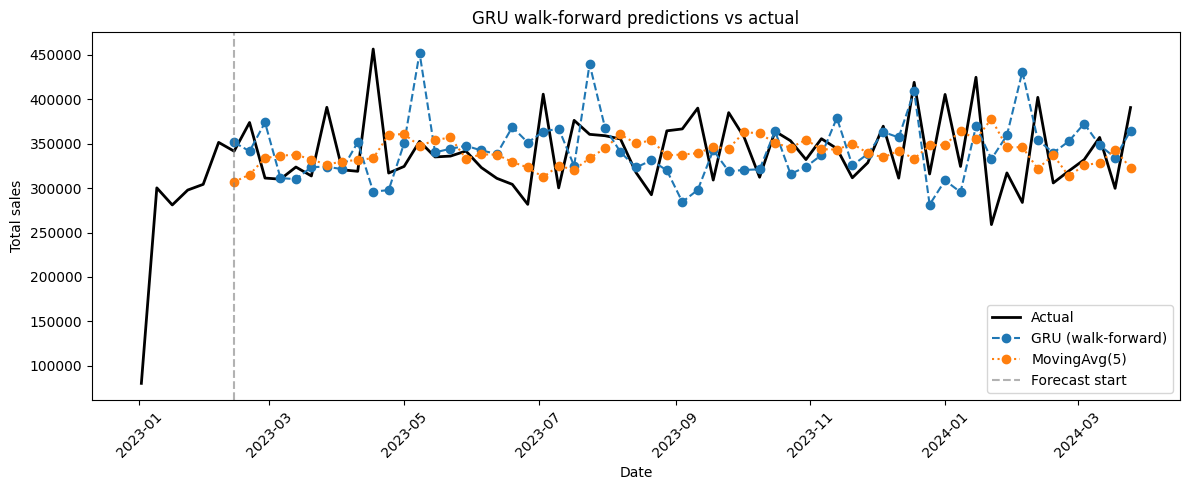

In [313]:
# Cell 11 - visualization
plt.figure(figsize=(12,5))
plt.plot(df[DATE_COL], df[TARGET_COL], label="Actual", color="black", linewidth=2)
plt.plot(results["Date"], results["gru_pred"], label="GRU (walk-forward)", marker="o", linestyle="--")
plt.plot(results["Date"], results["moving_avg"], label=f"MovingAvg({MA_WINDOW})", marker="o", linestyle=":")
plt.axvline(results["Date"].iloc[0], color="grey", linestyle="--", alpha=0.6, label="Forecast start")
plt.xlabel("Date")
plt.ylabel("Total sales")
plt.title("GRU walk-forward predictions vs actual")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [314]:
# Cell 12 - save predictions
results.to_csv("w6_multivariate_gru_walk_forward_predictions.csv", index=False)
print("Saved gru_walk_forward_predictions.csv")


Saved gru_walk_forward_predictions.csv
